<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/forecasting_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
US GDP data is released every three months. Is it possible to forecast the next GDP data release by using the data available from any source before then?

Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using these publically available sources, this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a handful of 'classically important' economic measures that economist's have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Numerical Data
Most of the numerical data are aggregated from direct measures of economic activity (such as dollar of goods sold, or number of building permits issued). Other numerical data are aggregations of surveys completed by participents in the economy (such as the PMI index, or the GDP Nowcast).

#### Textual Data
The textual data for this notebook is from the Institue for Supply Management's (ISM) Report on Business which is also the source of the some of the numerical data: PMI Index, and NMI Index. This report has been published on the first day of the month since the 1930s and it has had its name changed a few times.

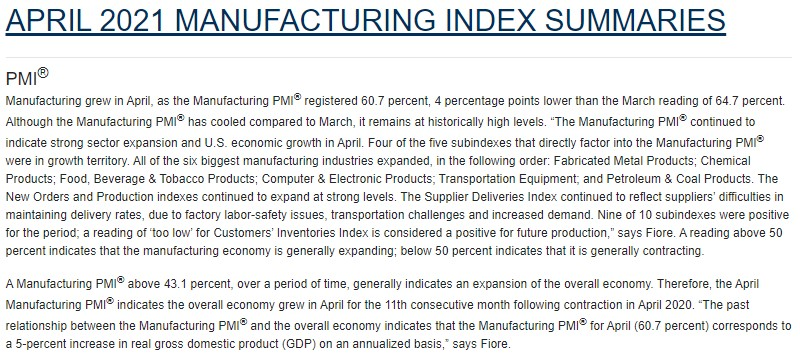


Along the numerical data in each report, the ISM summarizes the survey reponses in a few paragraphs the entire reprot, and for each subsection. Additionally, some subsections include a selection of quotes from survey responcess. These quote's are often 'soundbite-like' and add sentiment to an otherwise sentimentless report.

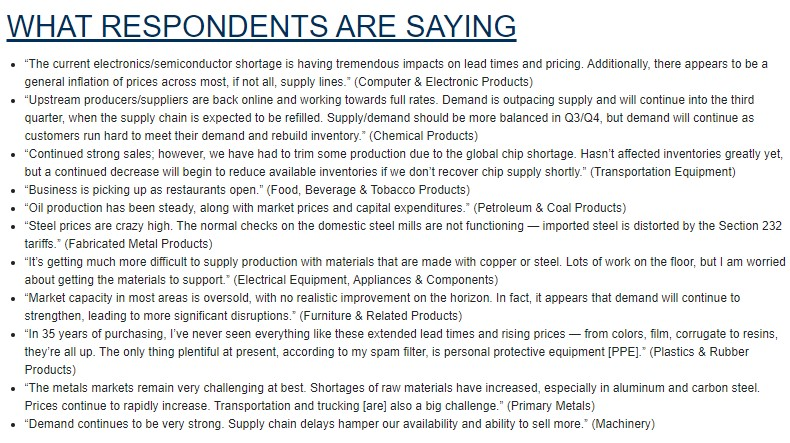



These textual summaries and quotes will be the input to the NLP model. 

## Todo List:
1. Scrape the text data from the PMI and NMI releases.
2. Approriately process the text data with nltk, GenSim, or similar.
3. Perform baseline modelling to choose a set of models to tune further.
4. Write up 
  * Exploration - talk about the important features
  * 3 important one, 3 non important ones
  * bivariate chart showing relation between them
  * show distributions
  * EDA: group categories with high-ratio and low-ratio, instead of having hundreds of categories.
  * Wrangling- describe manipulation and data changes
  * Methods
  * Make a plot n_sample for training, as a function of performance on the validation (always use the same test set). Look for a convergence of the performance after reaching sufficne samples. Use the best hyperparameters, not a grid search. (Try decision tree first, because it's fast.
  * discussion on each model, with summary of advs and disadvs of each model, assumptions
  * Most important  is to describe shortcomings of the data and analysis-room for improvement. Weaknesses/ limitations in the model. Show readers where the model and analysis can be improved.
  * Explain the choices made in the analysis
  * statistical tests of significance
  * Show chart with final perf on test set


## Completed list:
1. Gather and preprocess numerical data from Fed and Quandl.
2. Perform baseline modelling on the numerical data only.
* id important features have strong variation  with target var

# Imports

## Modules

In [27]:
# Set api key variables
% cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY


from pathlib import Path
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [28]:
! pip install -U numpy matplotlib seaborn
! pip install -U tsfresh tqdm requests_cache pandas-datareader 
! pip install -U tbats quandl scrapy beautifulsoup4 catch22 
! pip install -U statsmodels scipy hcrystalball pmdarima
! pip install -U pandas

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)
Requirement already up-to-date: tsfresh in /usr/local/lib/python3.7/dist-packages (0.18.0)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.7/dist-packages (4.61.1)
Requirement already up-to-date: requests_cache in /usr/local/lib/python3.7/dist-packages (0.6.4)
Requirement already up-to-date: pandas-datareader in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: tbats in /usr/local/lib/python3.7/dist-packages (1.1.0)
Requirement already up-to-date: quandl in /usr/local/lib/python3.7/dist-packages (3.6.1)
Requirement already up-to-date: scrapy in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: beautifulsoup4 in /usr/local/lib/python3.7/dist-packa

## Data Sources



### Numeric data from FRED and Quandl

In [29]:
data_series_ids = {
    'fred': {
        # GDP
        'A191RP1Q027SBEA': 'gdp_growth', # Target: GDP Growth, Percent Change from Preceding Period, Seasonally Adjusted Annual Rate
        'GDPC1': 'GDPC1', # Real Gross Domestic Product, chained 2012 dollars, for calculations later
        'GDP': 'GDP', # Gross Domestic Product (GDP), Units: Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        # Plotting helper
        'USRECD': 'is_recession', # NBER Recession indicator, retrospective only (not for forecasting)
        # Money Supply
        'WM2NS': 'M2', # M2 Money Stock, weekly, not seasonally adjusted
        # Interest Rates, 
        'FEDFUNDS': 'IR', # IR% : Effective Federal Funds Rate, monthly
        'T10YFF': 'IR_spread', # Interest rate spread (10-year Treasury vs. Effective Federal Funds Rate), Percent, Not Seasonally Adjusted, Daily
        # Inflation: Consumer and Business Inflation 
        'CPIAUCSL': 'CPI',  # CPI: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
        'CPILFESL': 'CPI_Core', # CPI Core: Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average
        'WPSFD49207': 'PPI', # PPI: Producer Price Index by Commodity: Final Demand: Finished Goods, Monthly
        'WPSFD4131': 'PPI_Core', # PPI Core: Producer Price Index by Commodity: Final Demand: Finished Goods Less Foods and Energy, Monthly
        # Employment
        # Employemnt Situation Report: http://data.bls.gov/pdq/SurveyOutputServlet?request_action=wh&graph_name=CE_cesbref1 
        'PAYEMS': 'employment', # All Employees, Total Nonfarm, Monthly
        'ICSA': 'initial_claims', # Average weekly initial jobless claims for unemployment insurance, Number, Seasonally Adjusted, Weekly
        'AWHMAN': 'weekly_hours', # Average Weekly Hours of Production and Nonsupervisory Employees, Manufacturing, Hours, Seasonally Adjusted, Monthly
        # Balance Sheets and Sovereign Risk
        'GFDEGDQ188S': 'debt_as_pct_of_gdp', # Federal Debt: Total Public Debt as Percent of GDP, Seasonally Adjusted
        'FYFSDFYGDP': 'surplus_or_deficit_as_pct_of_gdp', # Federal Surplus or Deficit [-] as Percent of GDP
        'FYOIGDA188S': 'interest_payments_as_pct_of_gdp', # Federal Outlays: Interest as Percent of GDP, annual
        'WGS10YR': '10_year_rates', # 10-Year Treasury Constant Maturity Rate
        'W018RC1Q027SBEA': 'total_receipts', # Federal government total receipts, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        # 'W019RCQ027SBEA': 'total_expenditures',
        'A091RC1Q027SBEA': 'interest_payments', # Federal government current expenditures: Interest payments, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        'WALCL': 'central_bank_total_assets', #  CB Balance Sheet: Assets: Total Assets: Total Assets (Less Eliminations from Consolidation): Wednesday Level, Units: Millions of U.S. Dollars, Not Seasonally Adjusted
        'STLENI': 'gdp_growth_nowcast',  # St Louis Fed's Real GDP Nowcast, Percent Change at Annual Rate, Seasonally Adjusted Annual Rate, Quarterly
        # Other classically leading indicators of gdp
        'UMCSENT': 'michigan_consumer_sentiment',  # Michigan sentiment survey index
        'PERMIT': 'building_permits', # New housing construction building  permits issued, monthly, seasonally adjusted annualized rate.
        'NEWORDER': 'new_orders_non_defense', # Manufacturers' New Orders: Nondefense Capital Goods Excluding Aircraft, Millions of Dollars, Seasonally Adjusted, Monthly
        }, 
    'quandl': {
        'ISM/MAN_PMI': 'PMI',
        'ISM/MAN_NEWORDERS': 'PMI_new_orders',
        'ISM/MAN_DELIV': 'PMI_deliv',
        # 'ISM/MAN_CUSTINV': 'PMI_custinv',
        # 'ISM/MAN_PRICES': 'PMI_prices',
        # 'ISM/MAN_EMPL': 'PMI_empl',
        # 'ISM/MAN_BACKLOG': 'PMI_backlog',
        # 'ISM/MAN_PROD': 'PMI_prod',
        # 'ISM/MAN_EXPORTS': 'PMI_exports',
        # 'ISM/MAN_INVENT': 'PMI_inventory',
        # 'ISM/MAN_IMPORTS': 'PMI_imports',
        # 'ISM/BUY_PROD_MAT': 'PMI_prod_mat',
        # 'ISM/BUY_MRO_SUPP': 'PMI_mro_supp',
        # 'ISM/BUY_CAP_EXP': 'PMI_cap_exp',
        'ISM/NONMAN_NMI': 'NMI',
        # 'ISM/NONMAN_BUSACT': 'NMI_bus_act',
        # 'ISM/NONMAN_EMPL': 'NMI_empl',
        'ISM/NONMAN_NEWORD': 'NMI_new_orders',
        # 'ISM/NONMAN_DELIV': 'NMI_deliv',
        # 'ISM/NONMAN_EXPORTS': 'NMI_exports',
        # 'ISM/NONMAN_INVENT': 'NMI_inventory',
        # 'ISM/NONMAN_BACKLOG': 'NMI_backlog',
        # 'ISM/NONMAN_IMPORTS': 'NMI_imports',
        # 'ISM/NONMAN_PRICES': 'NMI_prices',
        # 'ISM/NONMAN_INVSENT': 'NMI_invsent',
        }
  }
                      
# Group data series by frequency
series_by_freqs = {'W': ['M2',
                         '10_year_rates',
                         'IR_spread',
                         'central_bank_total_assets_as_pct_of_gdp',
                         'initial_claims',
                         'SP500'],
                   'M': ['IR',
                       'CPI',
                       'CPI_Core',
                       'PPI',
                       'PPI_Core',
                       'employment',
                       'weekly_hours',
                       'building_permits',
                       'PMI',
                       'NMI',
                       'michigan_consumer_sentiment',
                       'new_orders_non_defense'],
                   'Q': ['debt_as_pct_of_gdp',
                         'surplus_or_deficit_as_pct_of_gdp',
                         'liquidity_cover_ratio',
                         ],
                   'Y': ['interest_payments_as_pct_of_gdp']}

In [30]:
import pandas_datareader as pdr
import datetime
import quandl
import datetime
import requests_cache

# Get data from FRED
expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(1947, 4, 1)
end = datetime.datetime.today()

series_id_list = data_series_ids['fred'].keys()
params = {
    'api_key': API_KEY['fred'],
    'limit': 100000,
                }
df = pdr.fred.FredReader(series_id_list, 
                          start, end, 
                          session=session).read()
df.index = df.index.rename('date')

# Rename series with descriptive names
df = df.rename(columns=data_series_ids['fred'])

# Resample daily data to weekly
df['IR_spread'] = df['IR_spread'].resample('W').last()

# Calculate useful ratios then drop raw data
df['liquidity_cover_ratio'] = (df['total_receipts'] / 
                               (df['interest_payments'].fillna(method='ffill')))

df['central_bank_total_assets_as_pct_of_gdp'] = (df['central_bank_total_assets']/1000 / #Convert to Billions from Millions
                                                 (df['GDP'].fillna(method='ffill')) * 100)  # already in Billions

df['interest_payments_as_pct_of_gdp'] = df['interest_payments']/df['GDP']
df = df.drop(columns=['total_receipts',
                      'interest_payments',
                      # 'total_expenditures',
                      'central_bank_total_assets',
                      'GDP',
                      'GDPC1'])
# Plotting helpers
df['is_recession'] = df['is_recession'].astype(bool)

# Data from a second data source, Quandl
quandl.ApiConfig.api_key = API_KEY['quandl']

q_df_s = {}
for series_id in data_series_ids['quandl']:
  temp_df = quandl.get(series_id) # Returns a dataframe
  if len(temp_df.columns)==1:
    # Rename series with descriptive names
    temp_series = temp_df.squeeze().rename(data_series_ids['quandl'][series_id])
    q_df_s[series_id] = temp_series
  else:
    if 'Index' in temp_df.columns:
      temp_series = temp_df['Index'].rename(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
    elif 'Diffusion Index' in temp_df.columns:
      temp_series = temp_df['Diffusion Index'].rename(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
    else:
      temp_series = temp_df.add_prefix(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
q = pd.concat(list(q_df_s.values()), axis=1)
df = df.join(q, how='outer')
df.index = df.index.rename('date')

# Get data from third source: Stooq, for weekly SP500 data
df['SP500'] = pdr.data.DataReader('^SPX', 'stooq', start=start, end=end, session=session)['Close'].resample('W').last()

In [31]:
df.fillna(method='ffill')

,gdp_growth,is_recession,M2,IR,IR_spread,CPI,CPI_Core,PPI,PPI_Core,employment,initial_claims,weekly_hours,debt_as_pct_of_gdp,surplus_or_deficit_as_pct_of_gdp,interest_payments_as_pct_of_gdp,10_year_rates,gdp_growth_nowcast,michigan_consumer_sentiment,building_permits,new_orders_non_defense,liquidity_cover_ratio,central_bank_total_assets_as_pct_of_gdp,PMI,PMI_new_orders,PMI_deliv,NMI,NMI_new_orders,SP500
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1947-04-01,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-02,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-03,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-04,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-05,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06,11.0,True,20256.0,0.06,1.5,268.551,275.718,214.9,214.7,144894.0,376000.0,41.6,127.52159,-4.6399,0.024011,1.6,9.23,88.3,1733.0,74938.0,7.331581,35.971597,61.2,67.0,78.8,64.0,63.9,4229.89
2021-06-07,11.0,True,20256.0,0.06,1.5,268.551,275.718,214.9,214.7,144894.0,376000.0,41.6,127.52159,-4.6399,0.024011,1.6,9.23,88.3,1733.0,74938.0,7.331581,35.971597,61.2,67.0,78.8,64.0,63.9,4229.89
2021-06-08,11.0,True,20256.0,0.06,1.5,268.551,275.718,214.9,214.7,144894.0,376000.0,41.6,127.52159,-4.6399,0.024011,1.6,9.23,88.3,1733.0,74938.0,7.331581,35.971597,61.2,67.0,78.8,64.0,63.9,4229.89


# EDA

## Numerical Data

### Visually check the unprocessed data

In [32]:
# Plotting functions

def plot_subset_together(subset: list, ref_line=0):
  ax = sns.histplot(df[subset])
  if type(ref_line) != None:
    ax.axvline(ref_line, color='grey', linestyle='--')

def plot_subset(subset: list, ref_line=0):
  plt.rcParams.update({'figure.max_open_warning': 0})
  for col in subset:
    try:
      fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
      sns.scatterplot(data=df, x='date', y=col, ax=axes[0], hue='is_recession')
      sns.histplot(data=df, y=col, hue='is_recession', ax=axes[1])
      sns.boxplot(data=df, y=col, x='is_recession', ax=axes[2])
      if type(ref_line) != type(None):
        mean = df[col].mean()
        std = df[col].std()
        # if refline is within the 3*std of mean
        if (mean + 3*std > ref_line) and (mean - 3*std < ref_line):
          for ax in axes:
            ax.axhline(ref_line, color='grey', linestyle='--')
      plt.tight_layout()
    except ValueError as e:
      print(f'Error while plotting {col}')
      print(e)

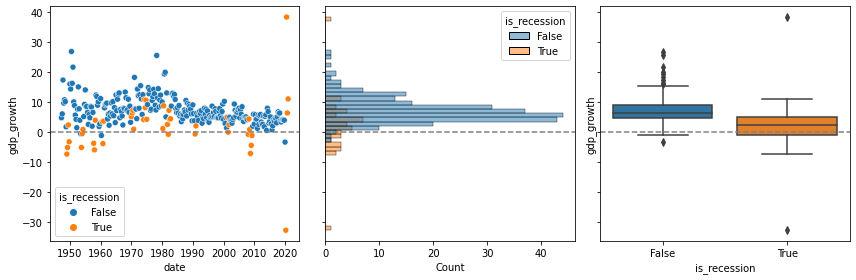

In [33]:
plot_subset(['gdp_growth'])

We see that the target variable appears stationary and fairly well-behaved for modeling.

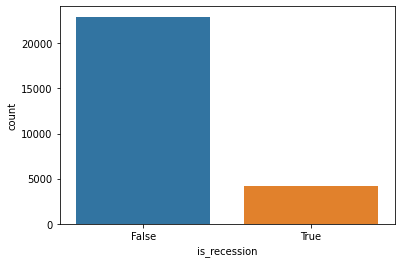

In [34]:
g= sns.countplot(x=df['is_recession'])
g.set(title='Number of days during recession vs number of days not in recession')

The minority of days are during recessions. Note that we only use this feature for plotting, not modeling. The definition of this data series states that it is a retrospective series.

In [35]:
unprocessed_subset = df.drop(columns=['gdp_growth', 'is_recession']).columns

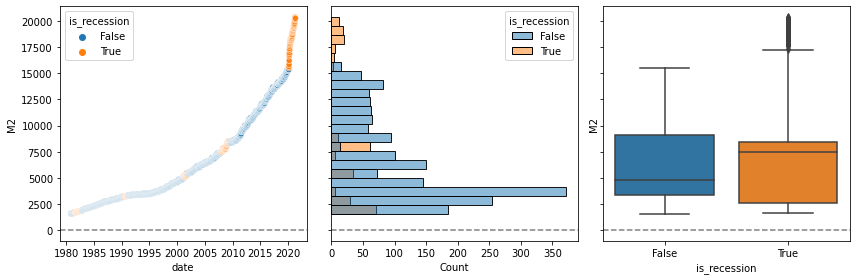

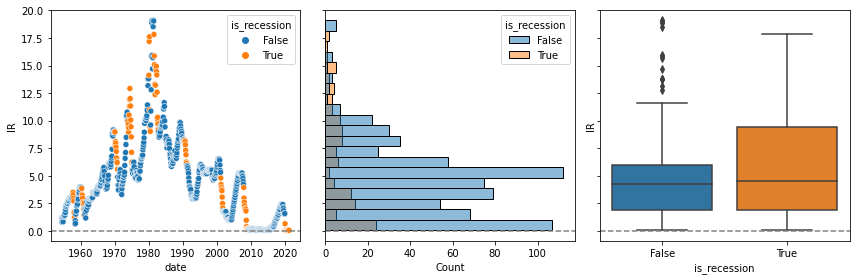

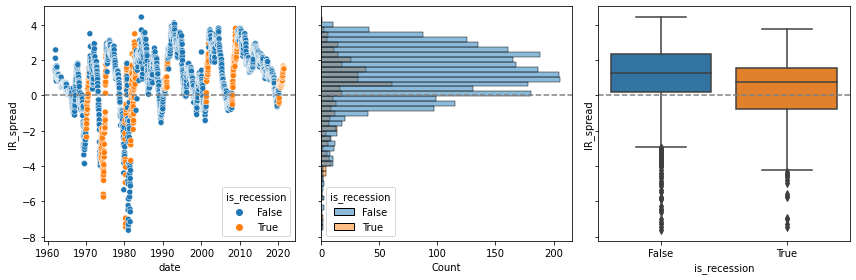

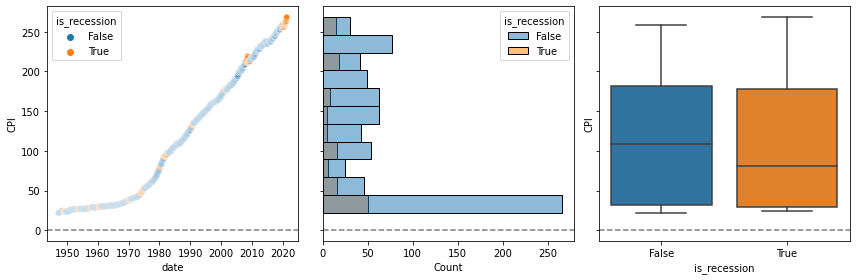

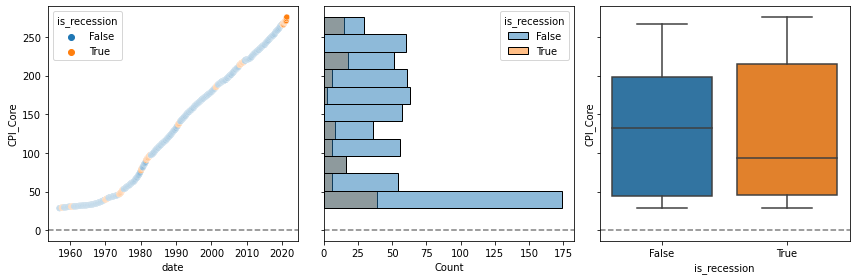

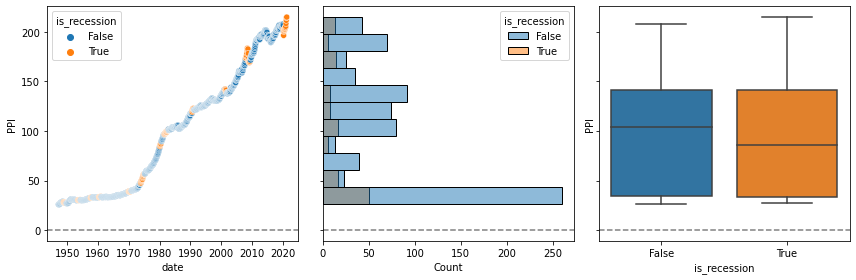

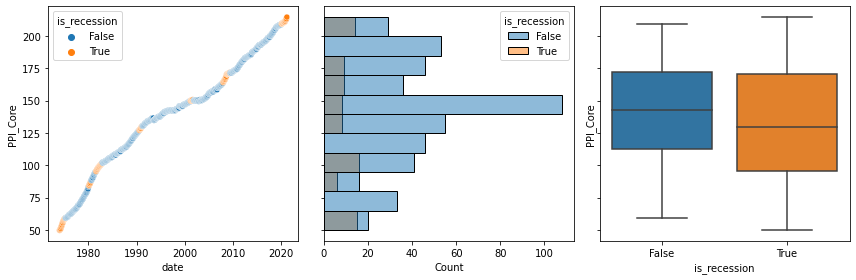

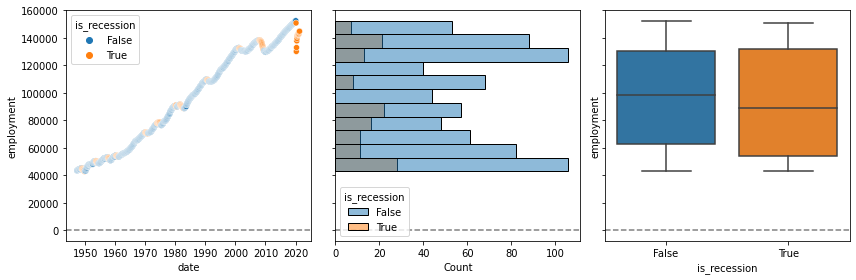

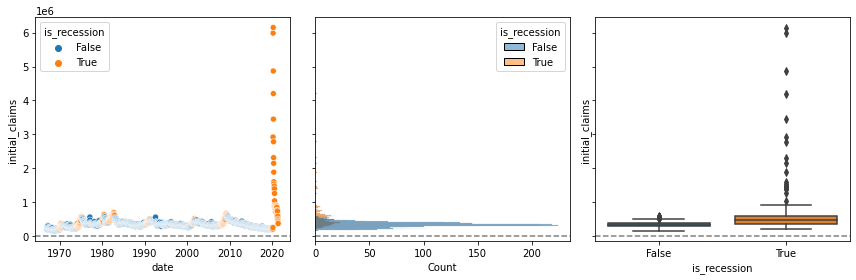

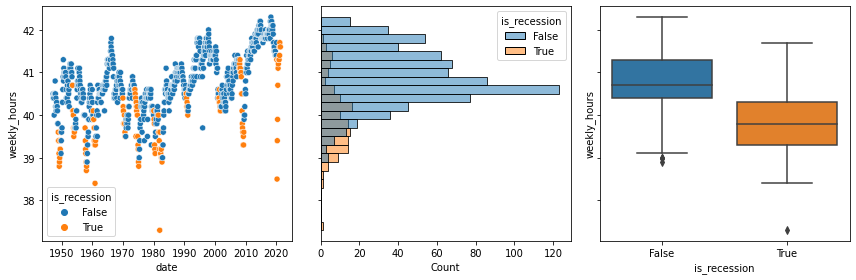

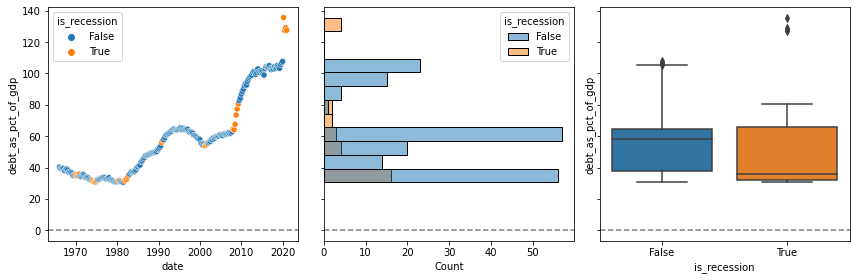

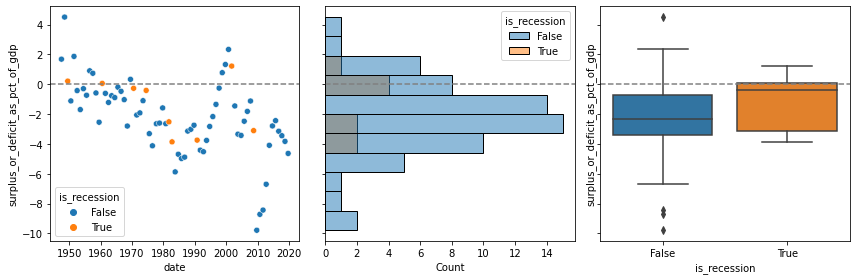

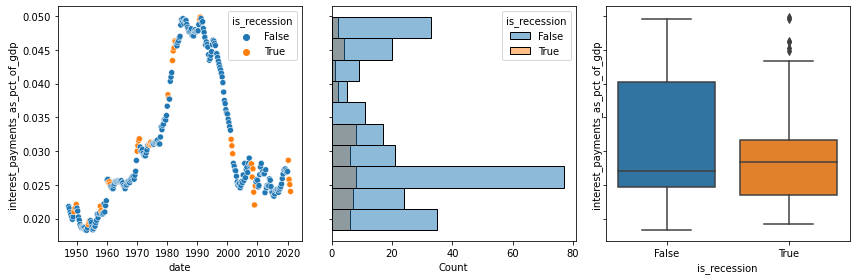

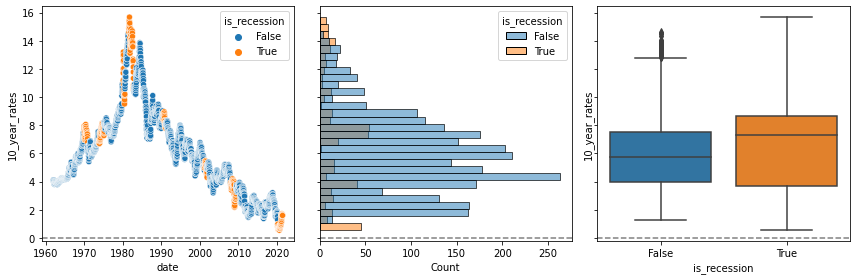

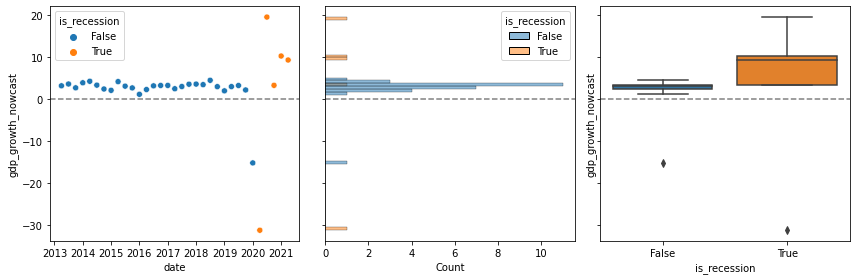

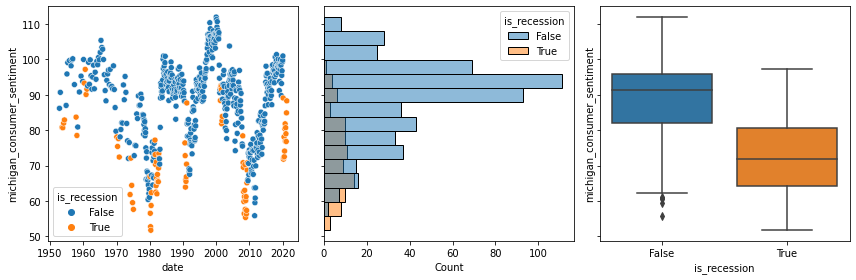

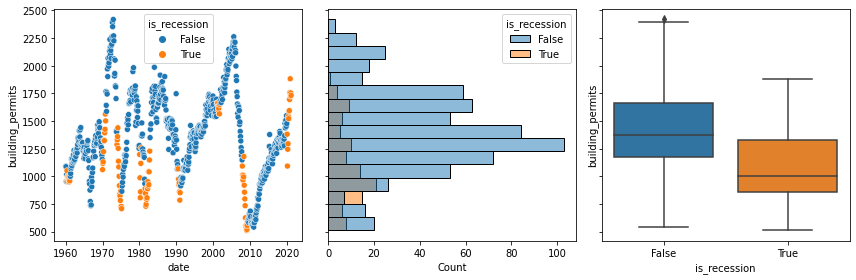

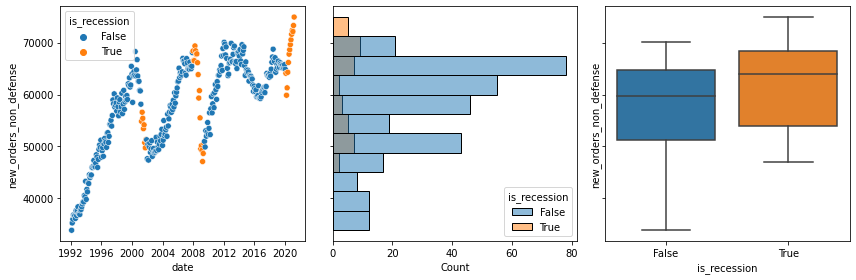

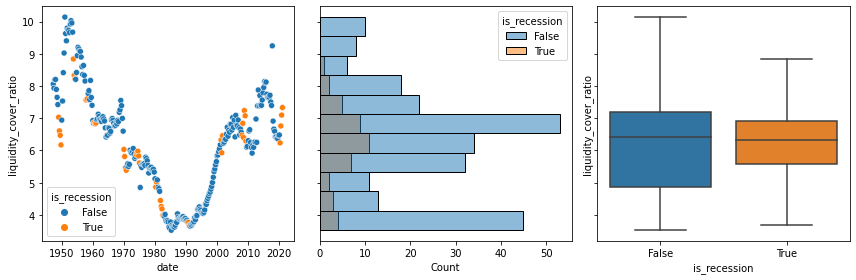

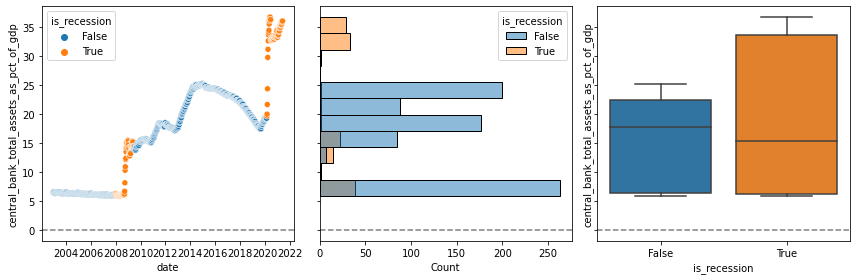

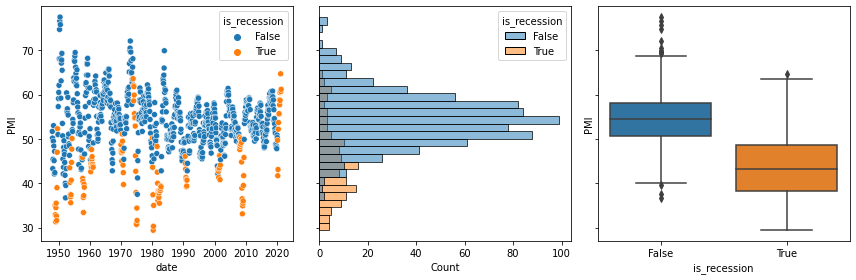

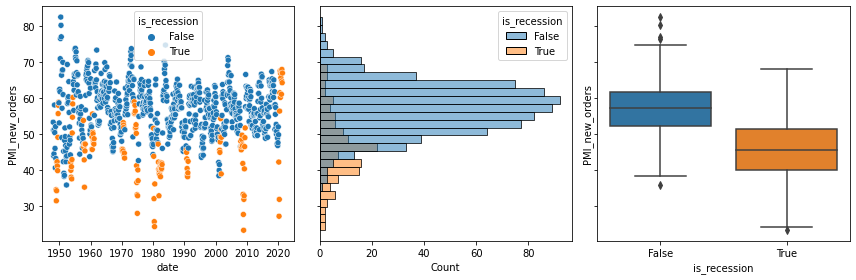

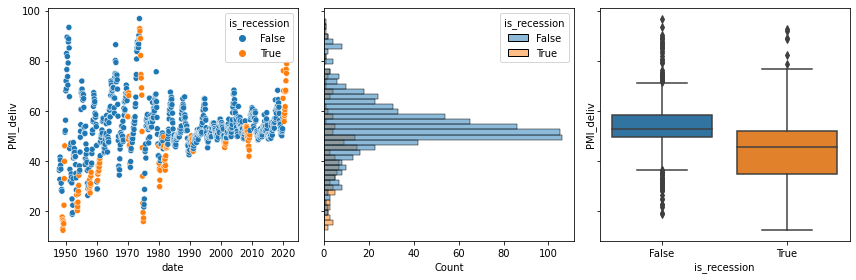

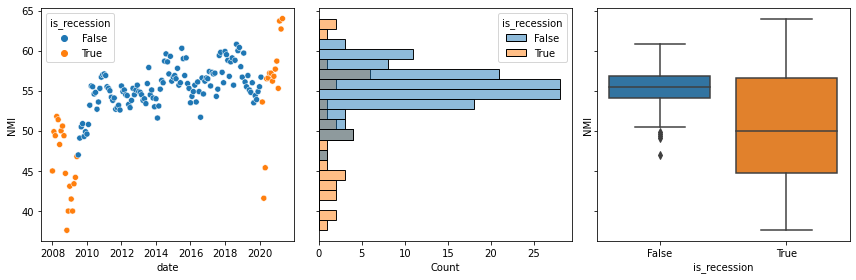

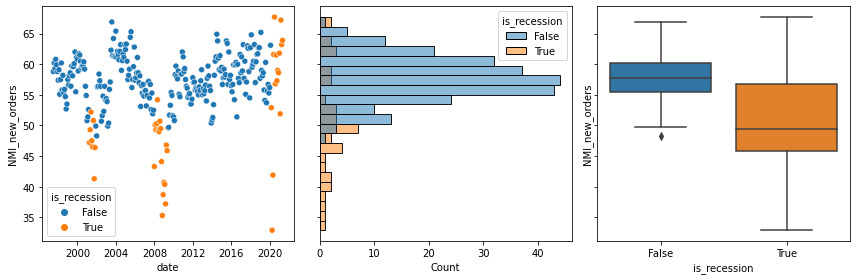

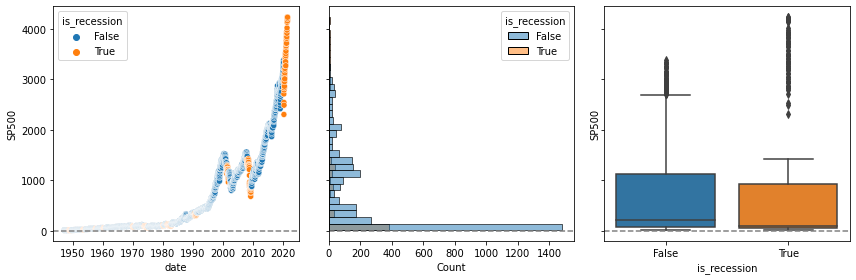

In [36]:
plot_subset(unprocessed_subset);

Most of the unprocessed series are not stationary, and require further processing before being useful in most models. 

## Textual Data

# Feature Engineering

## Numerical Data

### Manual Feature engineering

#### Derive about 50 new features from the original features

Calculate the percent change for features where that would make sense.

In [37]:
# Calculate pct_changes in weekly and monthly data, then drop raw data
switch = {'W': [1, 2, 3, 4, 8, 13, 26],
          'M': [1, 2, 3, 4, 5, 6],
          'Q': [1, 2],
          'Y': [1]} 

new_features_subset = []
for freq, series_list in series_by_freqs.items():
  periods = switch[freq]
  for series in series_list:
    for period in periods:
      col_name = f'{series}_{period}{freq}_pct_change'
      new_features_subset.append(col_name)
      df[col_name] = df[series].dropna().pct_change(periods=period).dropna()*100
    # df = df.drop(columns=[series])
print(f'Created {len(new_features_subset)} new features.')

Created 121 new features.


#### Visually Check the Derived Data Series

28
Error while plotting IR_spread_1W_pct_change
autodetected range of [-inf, inf] is not finite
Error while plotting IR_spread_13W_pct_change
autodetected range of [-inf, inf] is not finite


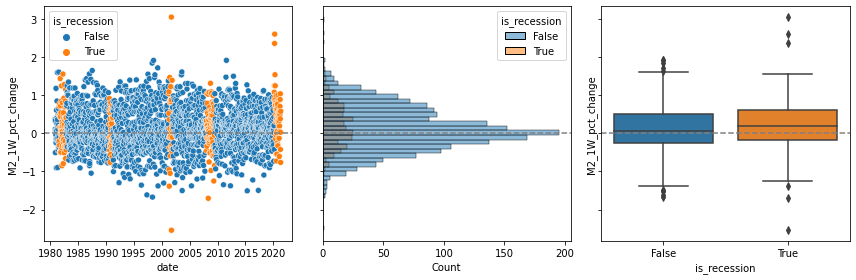

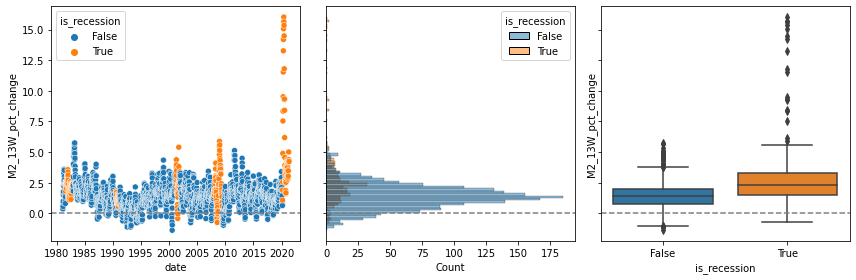

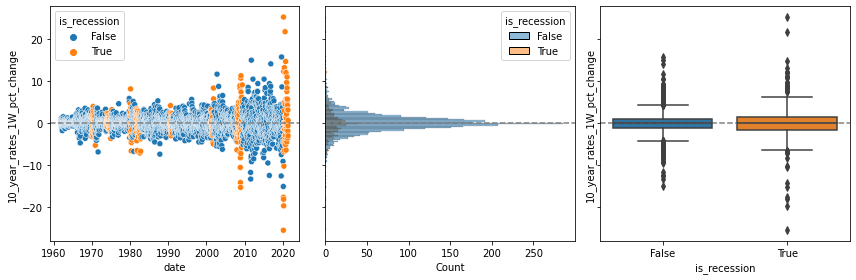

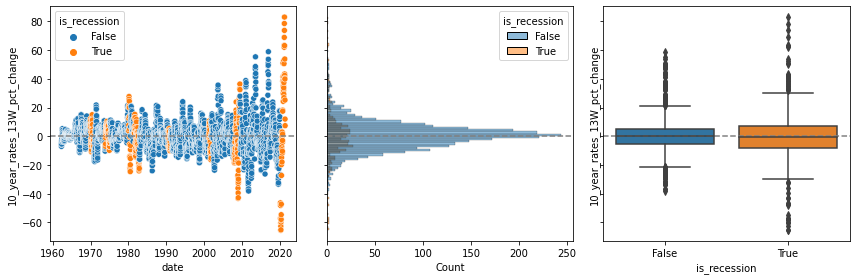

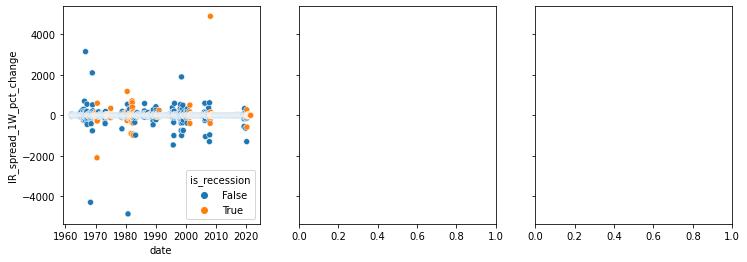

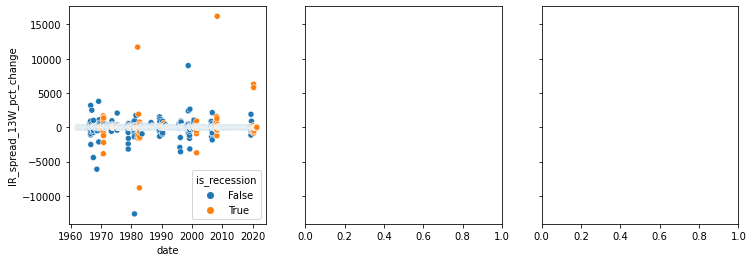

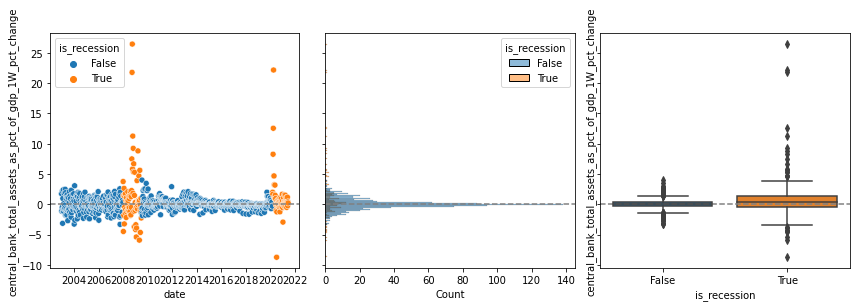

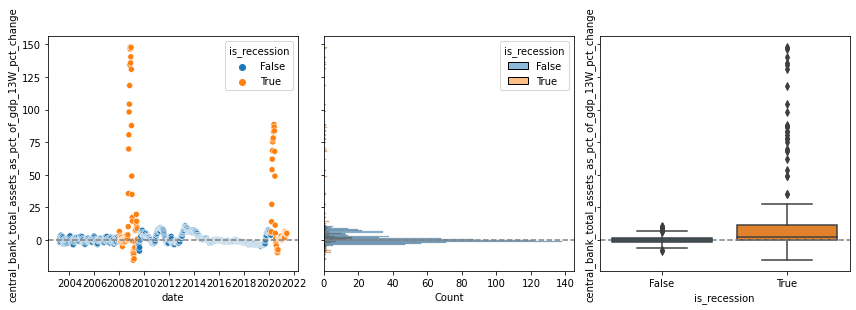

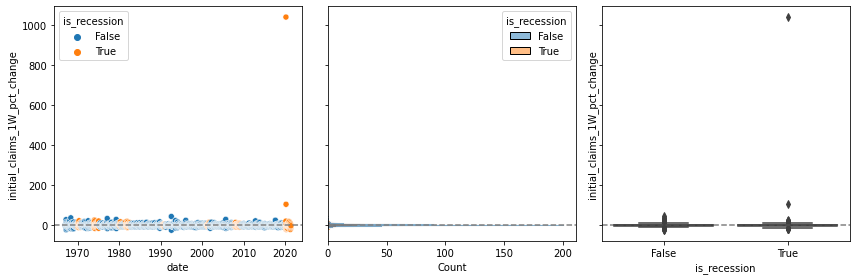

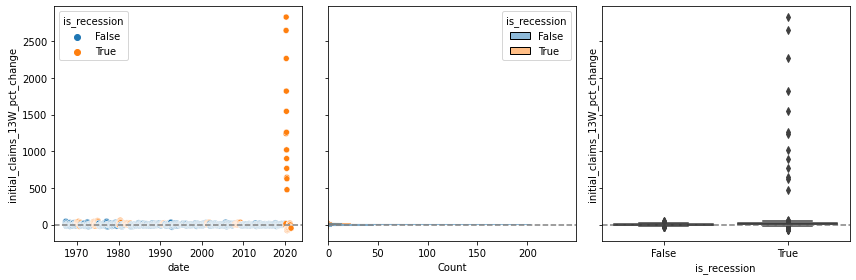

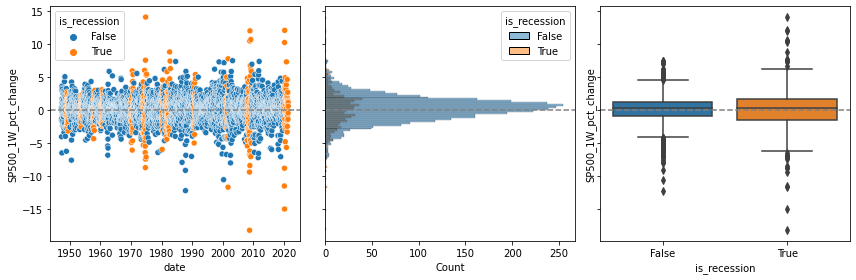

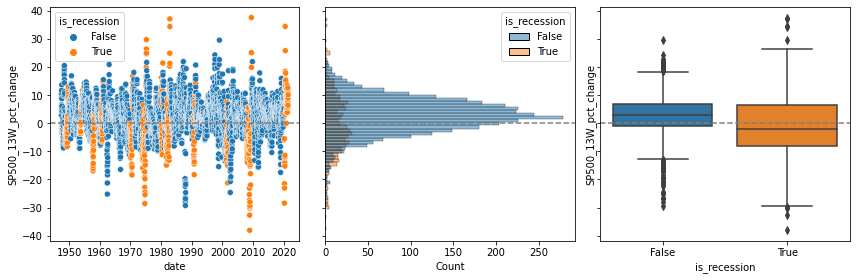

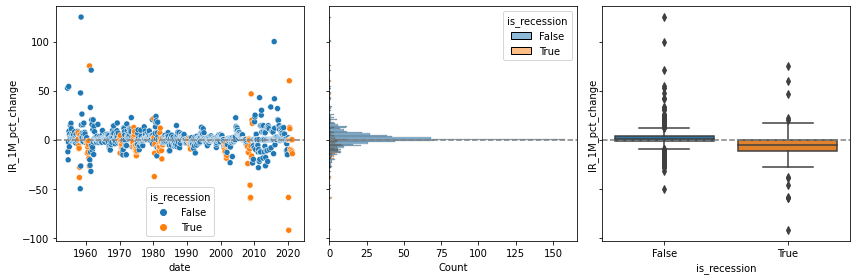

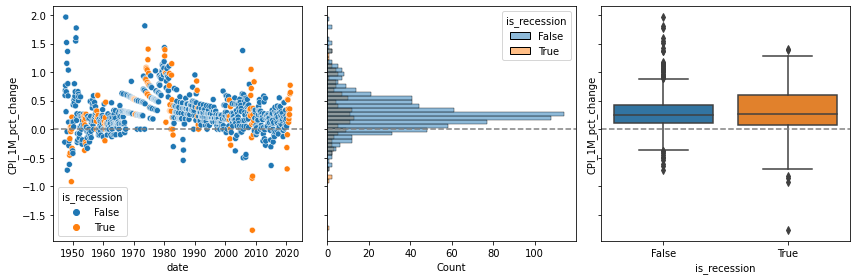

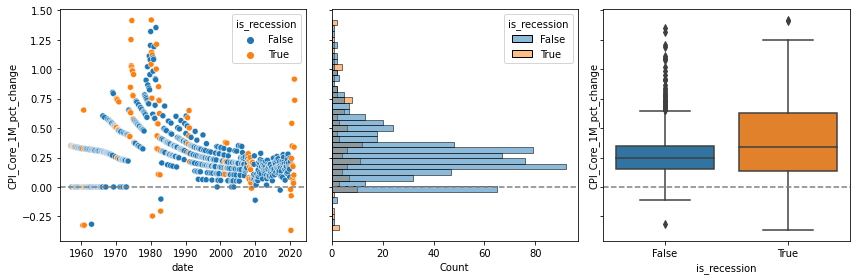

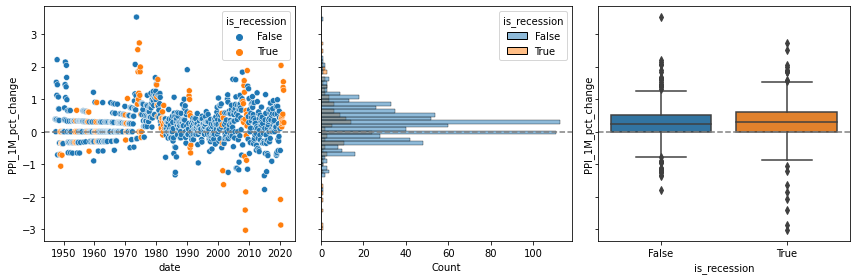

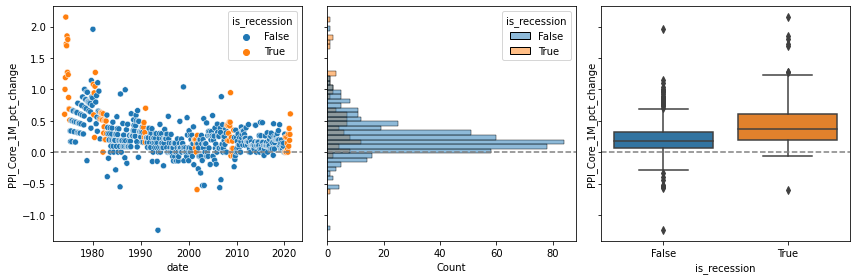

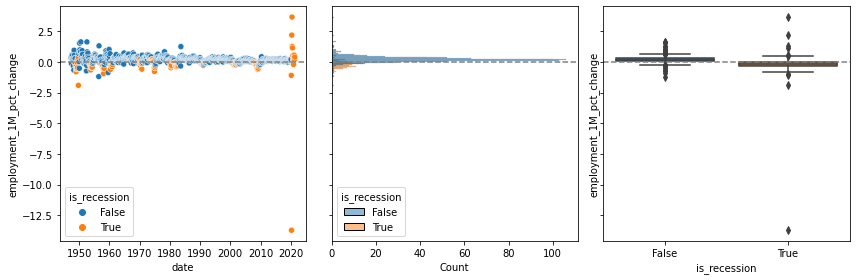

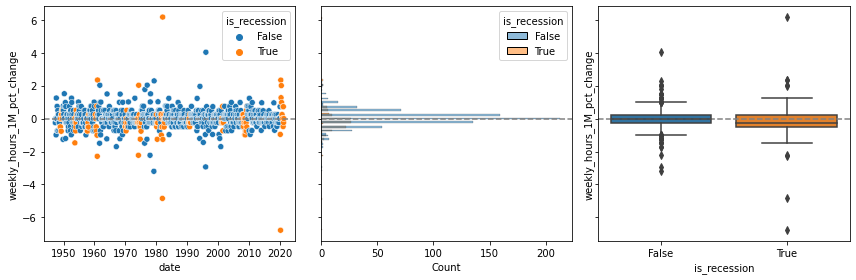

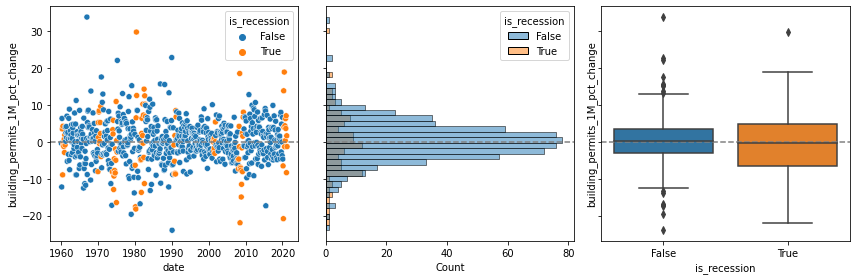

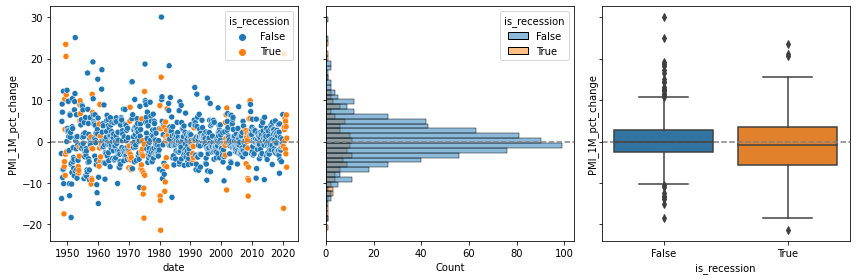

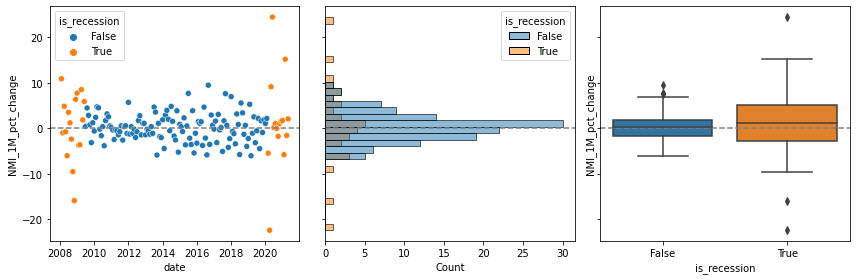

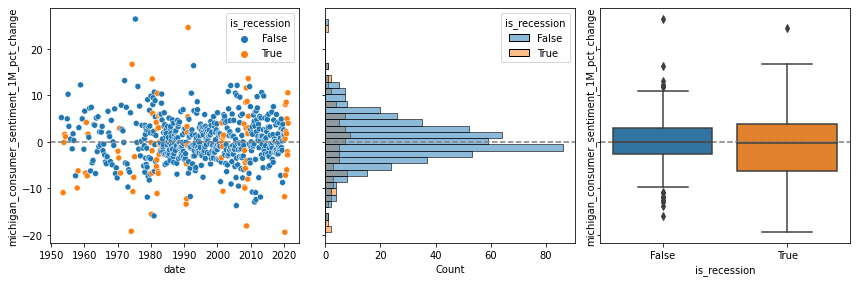

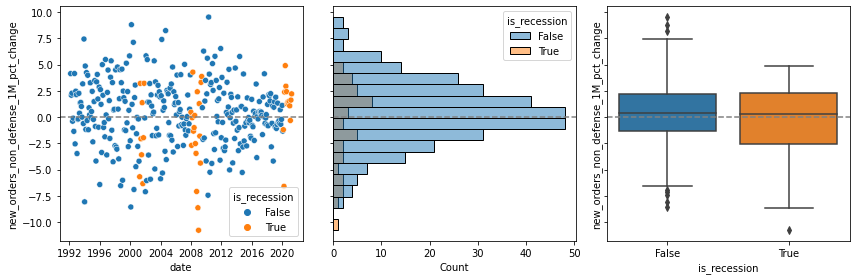

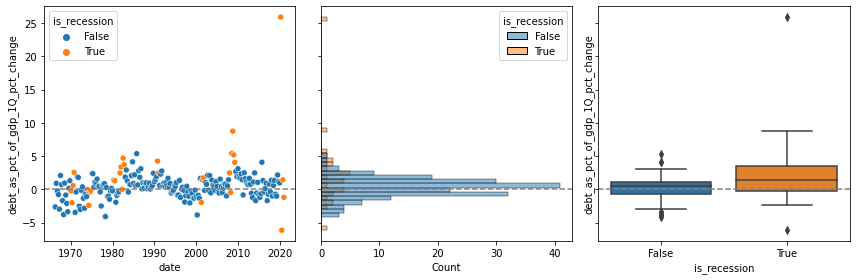

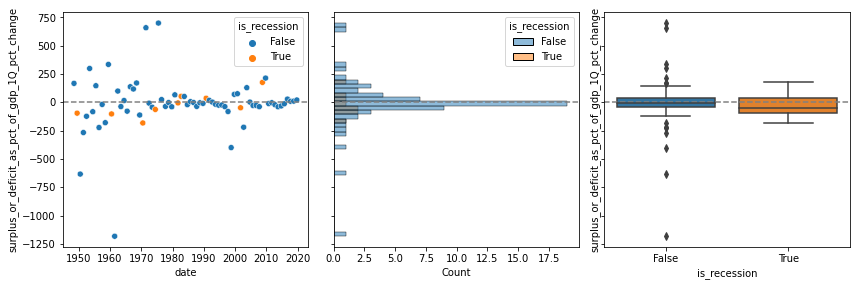

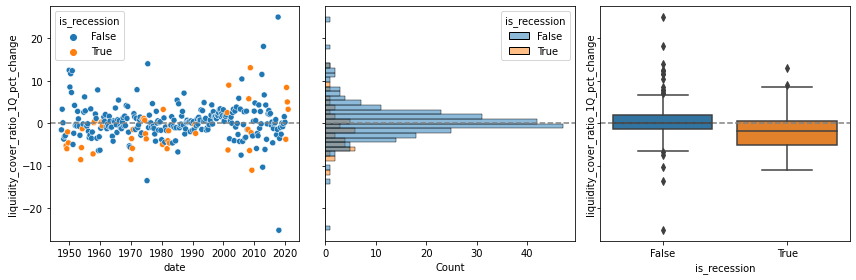

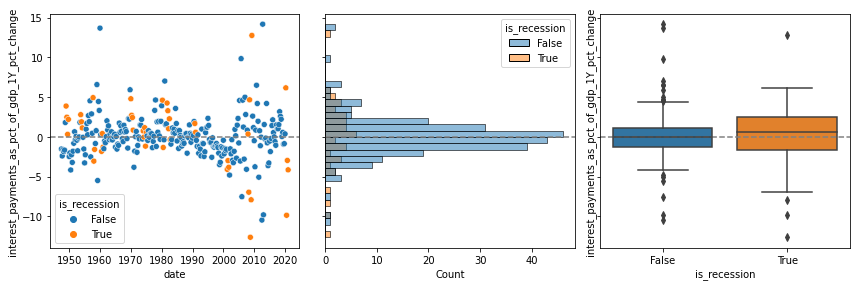

In [38]:
sample_new_columns = df[new_features_subset].filter(like='_1', axis=1).columns
print(len(sample_new_columns))
plot_subset(sample_new_columns)

### Automated Feature Engineering using tsfresh

#### Auto-generate over 14000 new features

In [85]:
from tsfresh.utilities.dataframe_functions import roll_time_series
import warnings

def roll_df(df, col, roll_len):
  temp = df[col].dropna() \
                .reset_index()\
                .assign(id=roll_len) \
                .rename(columns= \
                      {unprocessed_subset[0]: f"{unprocessed_subset[0]}_roll_{roll_len}"})
  if roll_len=='all':
    max_timeshift = None
    min_timeshift = 0
  else:
    max_timeshift = roll_len
    min_timeshift = roll_len
  df_rolled = roll_time_series(df_or_dict=temp, 
                              column_id="id", 
                              column_sort='date',
                              max_timeshift=max_timeshift, # max_timeshift (int) – If not None, the cut-out window is at maximum max_timeshift large. If none, it grows infinitely.
                              min_timeshift=min_timeshift, # min_timeshift (int) – Throw away all extracted forecast windows smaller or equal than this. Must be larger than or equal 0.
                              n_jobs=3,
                              disable_progressbar=True)
  # Save the intermediate dataframe
  with open(f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/rolled_dfs/{col}_roll_{roll_len}.pkl.gzip', 'wb') as f:
    df_rolled.to_pickle(f)
  return df_rolled

In [86]:
from tsfresh import extract_features, extract_relevant_features

def auto_generate_features_with_tsfresh(df_rolled: pd.DataFrame):

  extracted_features = extract_features(df_rolled, 
                                        column_id="id", 
                                        column_sort="date", 
                                        disable_progressbar=True,
                                        n_jobs=3)
  # # We make the data a bit easier to work with by removing the tuple-index
  extracted_features = extracted_features.set_index(extracted_features.index.map(lambda x: x[1]), drop=True)
  extracted_features.index.name = "date"
  
  return extracted_features

def load_rolled_df_and_extract_features(filepath):
  with open(filepath, 'rb') as f:
    df_rolled = pd.read_pickle(f)
  return auto_generate_features_with_tsfresh(df_rolled)

In [88]:
col

'gdp_growth_nowcast'

In [89]:
unprocessed_subset

Index(['M2', 'IR', 'IR_spread', 'CPI', 'CPI_Core', 'PPI', 'PPI_Core',
       'employment', 'initial_claims', 'weekly_hours', 'debt_as_pct_of_gdp',
       'surplus_or_deficit_as_pct_of_gdp', 'interest_payments_as_pct_of_gdp',
       '10_year_rates', 'gdp_growth_nowcast', 'michigan_consumer_sentiment',
       'building_permits', 'new_orders_non_defense', 'liquidity_cover_ratio',
       'central_bank_total_assets_as_pct_of_gdp', 'PMI', 'PMI_new_orders',
       'PMI_deliv', 'NMI', 'NMI_new_orders', 'SP500'],
      dtype='object')

In [91]:
for col in tqdm(unprocessed_subset[14:]):
  for roll_len in [10,20,40,'all']:
    try:
      roll_df(df, col=col, roll_len=roll_len)
    except KeyError as e:
      print('KeyError', col, e)

  0%|          | 0/12 [00:00<?, ?it/s]

KeyError gdp_growth_nowcast 'id'


In [ ]:
from pathlib import Path
 
directory = '/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/rolled_dfs/'
acc = []
for i, filepath in tqdm(list(enumerate(Path(directory).glob('*')))):
  extracted_features = load_rolled_df_and_extract_features(filepath)
  acc.append(extracted_features)
  # Save the intermediate dataframe
  with open(f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/extracted_features/{i}.pkl.gzip', 'wb') as f:
    extracted_features.to_pickle(f)
extracted_features = pd.concat(acc, axis=1)

  0%|          | 0/103 [00:00<?, ?it/s]

In [ ]:
extracted_features

The automated feature engineering created more than 14 thousand features from less than 30 original features. There are over 500 new features from each original feature, and the same from each lag (rolling window of about 10).

Now, we'll shift the feature backward by one day (to prevent leaking future information when making the prediction, and align the indexes of the target and the features.

In [ ]:
df_shift = extracted_features.fillna(method='ffill').shift(1)
y = df['gdp_growth'].dropna()
print(df_shift.shape, y.shape)
X = df_shift[df_shift.index.isin(y.index)]
y = y[y.index.isin(X.index)]

print(X.shape, y.shape)

#### Use dimensionality reduction: keep the best features (about 1%)

In [ ]:
X.dtypes

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

#Drop cols that are 100% NaN
perc = 100 # Like N %
min_count =  int(((100-perc)/100)*X.shape[0] + 1)
X = X.dropna(axis=1,thresh=min_count)

#Impute 
impute(X)
selected_features_df = select_features(X, y)
selected_features_subset = selected_features_df.columns
selected_features_df

As expected, the vast majority of the auto-generated features were not predictive of the target variable. Almost 90% of the features were discarded and only about 2000 remain.

Let's tally up the useful autogenerated features and see if we can draw any conclusions about which data sereis they were generated from.

In [ ]:
new_col_components_list = [col_name.split('__') for col_name in list(selected_features_subset)]
original_data_series_list = [ count[0] for count in new_col_components_list]
feature_caluclation_type_list = [count[1] for count in new_col_components_list if len(count)>1]

new_col_components_series = pd.Series(new_col_components_list, name='new_col_components')
original_data_series_series = pd.Series(original_data_series_list, name='original_data_series')
feature_caluclation_type_series =  pd.Series(feature_caluclation_type_list, name='feature_caluclation_type')


In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(y = original_data_series_series,
              order = original_data_series_series.value_counts().index)

Surprisingly, the gdp nowcast, an indicator that is designed to forecast the next GDP news release, is not found to be useful the the feature selection algorithm.

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(y = feature_caluclation_type_series,
              order = feature_caluclation_type_series.value_counts()[:25].index);

The plot shows that cwt_coefficients, change_quantiles, and agg_linear_trend are the most useful feature generation calculations, as these two algorithms generated about half of the useful features.

In [ ]:
# Make a useful function to select from the extracted features and generate X and y
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

def select_features_and_make_X_and_y(extracted_features: pd.DataFrame, y: pd.Series, plots: bool=False, debug: bool=False):
  df_shift = extracted_features.fillna(method='ffill').shift(1)
  y = y.dropna()
  if debug:
    print(df_shift.shape, y.shape)
  X = df_shift[df_shift.index.isin(y.index)]
  y = y[y.index.isin(X.index)]
  if debug:
    print(X.shape, y.shape)

  #Drop cols that are 100% NaN
  perc = 100 # Like N %
  min_count =  int(((100-perc)/100)*X.shape[0] + 1)
  X = X.dropna(axis=1,thresh=min_count)
  if debug:
    print(X.shape, y.shape)
  
  #Impute 
  impute(X)
  X = select_features(X, y)
  assert X.shape[0]==y.shape[0]
  assert X.isna().values.any()==False
  assert y.isna().values.any()==False
  if plots:
    new_col_components_list = [col_name.split('__') for col_name in list(X)]
    original_data_series_list = [ count[0] for count in new_col_components_list]
    feature_caluclation_type_list = [count[1] for count in new_col_components_list if len(count)>1]

    new_col_components_series = pd.Series(new_col_components_list, name='new_col_components')
    original_data_series_series = pd.Series(original_data_series_list, name='original_data_series')
    feature_caluclation_type_series =  pd.Series(feature_caluclation_type_list, name='feature_caluclation_type')

    fig, ax = plt.subplots(2, 1, figsize=(6,10))
    sns.countplot(y = original_data_series_series,
                  order = original_data_series_series.value_counts().index,
                  ax=ax[0])
    sns.countplot(y = feature_caluclation_type_series,
                  order = feature_caluclation_type_series.value_counts()[:20].index,
                  ax=ax[1])
  return X, y

X, y = select_features_and_make_X_and_y(extracted_features, df['gdp_growth'], plots=True)

## Textual Data

In [ ]:
## Todo

# Trade-off between length of training period, and number of available data sources

Ideally, we'd like to train the model with all the data over the longest period possible. However, some data series are fairly new--less than 10 year old--while others have quite a long history spanning multiple decades. 

In [ ]:
first_valid_loc = df[unprocessed_subset] \
                    .apply(lambda col: col.first_valid_index())
start_dates =  pd.Index(first_valid_loc.sort_values().unique())

num_of_notna = pd.Series(dtype=object)
for start_date in start_dates:
  num_of_notna[start_date] = len(df.drop(columns=['gdp_growth', 'is_recession'])
                                   .fillna(method='ffill')
                                   .loc[start_date:]
                                   .dropna(axis=1).columns)
  
# Plot Number of available data series from various start dates
num_of_notna.plot.area()
plt.xlabel('Date of first data point')
plt.ylabel('Count')
plt.title('Number of available data series from various start dates')

first_valid_loc.sort_values()

We will address this trade-off by cross-validating baseline models on slices of the training data with various start dates. Longer training periods (starting earlier) will have fewer sources data series, while shorter training peroids (starting later) will have access to more source data series. 

It will be interesting to see if the few long-running data series are more useful than abundance of newly-introduced data series when predicting the GDP. 

## Compare the number of useful generated features by start date

In [ ]:
X_and_y.keys()

In [ ]:
import matplotlib.dates as mdates

# Calculate X and y for all start_dates
X_and_y = {}
for start_date in tqdm(start_dates, desc='start_dates'):
  X, y = select_features_and_make_X_and_y(extracted_features.loc[start_date:], df['gdp_growth'].loc[start_date:])
  X_and_y[start_date] = (X, y)

# Caluclate number of useful engineered features for each start date
num_useful_features = {}
plt_num_useful_features = {}
for start_date in start_dates:
  X, _ =  X_and_y[start_date]
  num_useful_features[start_date] = len(X.columns)
  plt_num_useful_features[start_date.date()] = len(X.columns)
num_useful_features = pd.Series(num_useful_features, name='number_of_useful_features')

# Plot number of useful feature for each startdate
plt_num_useful_features = pd.Series(plt_num_useful_features, name='number_of_useful_features')
plt_num_useful_features.index.name = 'start_date'
plt_num_useful_features.plot(kind='bar')
plt.xlabel('Start Date')
plt.ylabel('Number of Features')
plt.title('Number of engineered features after diminsionality reduction, by start date')
plt.show()

We can see that any start date after 1992 does not have any useful features after dimensionality reduction. For modeling, we will use the start dates before 1992.

In [ ]:
start_dates_subset = num_useful_features[num_useful_features>0].index
start_dates_subset

# Modelling

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [ ]:
def model_fit_and_predict_all_start_dates(regressor_class, 
                                          features_df, 
                                          target_series,
                                          params={}, 
                                          n_splits=65, 
                                          test_size=1,
                                          plots=True):
  n_splits = n_splits
  test_size = test_size
  params = params

  pred_df= pd.DataFrame()
  y_true = pd.Series(dtype=float)
  pred_df.index.name = 'train_start_date'
  pred_df = pred_df.T
  pred_df.index.name = 'forecast_date'

  for train_start_date in tqdm(start_dates_subset, desc='train_start_dates'):
    # print(f'\ntraining start_date:\t{train_start_date}')
    X, y = X_and_y[train_start_date]
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    pred_series = pd.Series(dtype=float, name='pred')
    for train_indices, test_indices in tscv.split(X):
      try:
        X_train = X.iloc[train_indices,:]
        X_test = X.iloc[test_indices,:]
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
        # print( X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        forecast_date = y.iloc[test_indices].index.values[0]
        y_true[forecast_date] = y[forecast_date] 
        # print(f'forecast_date: {forecast_date}')
        
        regressor = regressor_class()
        # regressor.set_params(params)
        regressor.fit(X_train.values, y_train.values)

        y_pred = regressor.predict(X_test)
        pred_series[forecast_date] = y_pred[0] if test_size==1 else y_pred
      except ValueError as e:
        print(f'ValueError:{e}')
        

  # Save the model
  import pickle
  model_path = f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/models/{model_name}.pkl'
  with open(model_path, 'wb') as f:
    pickle.dump(regressor, f)

  # save dataframe
  save_path = f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/{model_name}_pred_df.pkl'
  with open (save_path, 'wb') as f:
    pickle.dump(pred_df, f)

  if plots:
    y_true = y_test
    # Plot predictions at various train_start_dates
    plot_predictions(pred_df, y_true)

    # Plot the abs_error at various train start_dates
    plot_absolute_error(pred_df, y_true)

    # Plot the feature importances at various train start_dates
    plot_feature_importances(pred_df)

  return regressor, pred_df


def plot_predictions(pred_df, y_true):
    plt.subplots(figsize=(10,6))
    pred_df.plot(ax=plt.gca(), alpha=0.5)
    plt.title(f'{model_name}: one-period-ahead forecast of gdp_growth')
    plt.ylabel('Prediction of gdp_growth')
    y_true.plot(ax=plt.gca(), linestyle='--')

def plot_absolute_error(pred_df, y_true):
    abs_error = pred_df.apply(lambda col: (col - y_true).abs())
    mae = abs_error.mean() 
    plt.subplots(figsize=(10,6))
    abs_error.plot(ax=plt.gca(), alpha=0.5)
    plt.title(f'{model_name}: one-period-ahead forecast of gdp_growth')
    plt.ylabel('Absolute Error')
    plt.show()

def plot_feature_importances(regressor):
  plt.figure(figsize=(10,6))
  try: # Tree type models
    feat_imp = regressor.feature_importances_
  except: # Linear models
    feat_imp = regressor.coef_
  pd.Series(np.abs(feat_imp), index=X.columns) \
    .nlargest(20) \
    .sort_values(ascending=True) \
    .plot(kind='barh')
  plt.title(f'{model_name}: feature importances')
  
# model, pred_df = model_fit_and_predict_all_start_dates(DecisionTreeRegressor, 
#                                                           extracted_features, 
#                                                           df['gdp_growth'])

## Decision Tree

In [ ]:
regressors = {}
pred_df_s = {}

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model_name = 'Decision Tree'
regressor_class = DecisionTreeRegressor
params={}

regressors['dt'], pred_df_s['dt'] = model_fit_and_predict_all_start_dates(regressor_class, 
                                                          extracted_features, 
                                                          df['gdp_growth'],
                                                          params=params)



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_name = 'Random Forest'
regressor_class = RandomForestRegressor

regressors['lr'], pred_df_s['lr'] = model_fit_and_predict_all_start_dates(regressor_class, 
                                                          extracted_features, 
                                                          df['gdp_growth'])


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model_name = 'Linear Regression'
regressor_class = LinearRegression
params = {}

regressors['lr'], pred_df_s['lr'] = model_fit_and_predict_all_start_dates(regressor_class, 
                                                          extracted_features, 
                                                          df['gdp_growth'],
                                                          params=params)

## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

model_name = 'ElasticNet'
regressor_class = ElasticNet

regressors['en'], pred_df_s['en'] = model_fit_and_predict_all_start_dates(regressor_class, 
                                                          extracted_features, 
                                                          df['gdp_growth'])

## SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor

model_name = 'SGDRegressor'
regressor_class = SGDRegressor

regressors['sgd'], pred_df_s['sgd'] = model_fit_and_predict_all_start_dates(regressor_class, 
                                                          extracted_features, 
                                                          df['gdp_growth'])

## hcrystalball: a time-series modelling module that unifies the api of various modelling modules

In [ ]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X, y = select_features_and_make_X_and_y(extracted_features, df['gdp_growth'])

from hcrystalball.model_selection import ModelSelector

ms = ModelSelector(horizon=1,
                   frequency='Q'
                  )

ms.create_gridsearch(sklearn_models=True,
                    n_splits = 65,
                    # between_split_lag=0,
                    sklearn_models_optimize_for_horizon=False,
                    autosarimax_models=False,
                    prophet_models=True,
                    tbats_models=True,
                    exp_smooth_models=True,
                    average_ensembles=False,
                    stacking_ensembles=False,
                    # exog_cols=list(X.select_dtypes(include=np.number).columns),
#                     holidays_days_before=2,
#                     holidays_days_after=1,
#                     holidays_bridge_days=True,
                    )

#SkLearn models
from hcrystalball.wrappers import get_sklearn_wrapper

# Most sklearn models benefit from scaling of numeric features
sklearn_native_transformers = TSColumnTransformer(
    transformers=[
        ('scaler', 
          StandardScaler(), 
          list(X.select_dtypes(include=np.number).columns)
        )
        ])

# Decision Tree 
from sklearn.tree import DecisionTreeRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(DecisionTreeRegressor, name='dt'))
            ]))

# Random Forest
from sklearn.ensemble import RandomForestRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(RandomForestRegressor, name='rf'))
            ]))

# Linear Regression
from sklearn.linear_model import LinearRegression
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(LinearRegression, name='lr'))
            ]))



# from hcrystalball.wrappers import SarimaxWrapper
# ms.add_model_to_gridsearch(SarimaxWrapper(init_with_autoarima=True))

from hcrystalball.wrappers import ProphetWrapper
ms.add_model_to_gridsearch(ProphetWrapper())

from hcrystalball.wrappers import ExponentialSmoothingWrapper
ms.add_model_to_gridsearch(ExponentialSmoothingWrapper())

from hcrystalball.wrappers import TBATSWrapper
ms.add_model_to_gridsearch(TBATSWrapper())

# from hcrystalball.wrappers import SimpleSmoothingWrapper
# from hcrystalball.wrappers import HoltSmoothingWrapper
# from hcrystalball.wrappers import BATSWrapper

ms.select_model(df=X.join(y),
                target_col_name='gdp_growth',
                # persist_model_selector_results=False,
                # output_path='my_results',
               )

In [ ]:
ms.plot_results(plot_from='2005', figsize=(20,15));

In [ ]:
ms.results[0].cv_results.set_index('rank_test_score').sort_index()

We can see that TBATS is over 500 times slower than the best model while still no 

In [ ]:
ms.results[0].best_model_cv_results